In [33]:
import numpy as np
from six import raise_from
import csv
import sys
import os
from collections import OrderedDict
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [34]:
#Mount google drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [35]:
def process_data(data_file, processed_data_file):
  csv_reader = csv.reader(data_file)
  csv_writer = csv.writer(processed_data_file)
  header = next(csv_reader)
  header.append("class")
  csv_writer.writerow(header)
  labels_summary = [0, 0, 0, 0, 0, 0]
  for row in csv_reader:
    write = True
    line = row[:3]
    if float(row[2]) <= 15.060212:
      label = 0
      labels_summary[0] += 1
      line.append("Istra")
    elif float(row[1]) <= 45.144818 and float(row[1]) >= 44.270341 and float(row[2]) <= 16.339540:
      label = 1
      labels_summary[1] += 1
      line.append("Lika")
    elif float(row[1]) < 44.270341:
      label = 2
      labels_summary[2] += 1
      line.append("Dalmacija")
    elif float(row[1]) >= 45.987003:
      label = 3
      labels_summary[3] += 1
      line.append("Sjever")
    elif float(row[2]) >= 17.641999:
      label = 4
      labels_summary[4] += 1
      line.append("Slavonija")
    else:
      label = 5
      labels_summary[5] += 1
      line.append("Sredisnja")
    if labels_summary[label] <= 1744:
      csv_writer.writerow(line)
    # csv_writer.writerow(line)

In [36]:
processed_annotations_path = os.path.abspath("./gdrive/MyDrive/lumen/processed_annotations.csv")
annotations_path = os.path.abspath("./gdrive/MyDrive/lumen/data.csv")
processed_annotations_file = open(processed_annotations_path, 'w')
annotations_file = open(annotations_path)

In [37]:
process_data(annotations_file, processed_annotations_file)
annotations_file.close()
processed_annotations_file.close()

In [38]:
def get_coord(annotations_path):
  x_coord = []
  y_coord = []
  processed_annotations_file = open(annotations_path, 'r')
  csv_reader = csv.reader(processed_annotations_file)
  header = next(csv_reader)
  for row in csv_reader:
    x_coord.append(float(row[2]))
    y_coord.append(float(row[1]))
  processed_annotations_file.close()
  return x_coord, y_coord

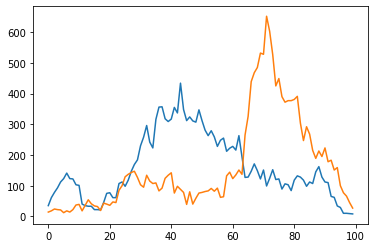

In [39]:
x_coord, y_coord = get_coord(processed_annotations_path)
x_min = min(x_coord)
y_min = min(y_coord)
x_max = max(x_coord)
y_max = max(y_coord)
## Scale from 0 to 1
x_coord = [(i-x_min)/(x_max-x_min) for i in x_coord]
y_coord = [(i-y_min)/(y_max-y_min) for i in y_coord]

## Create histograms
hist_x, bin_edges_x = np.histogram(x_coord, bins=100, density=False)
hist_y, bin_edges_y = np.histogram(y_coord, bins=100, density=False)
plt.plot(hist_x)
plt.plot(hist_y)

In [40]:
def transform(hist, bin_edges, file_path):
  target_range_start=0
  transformation = []
  n_samples = sum(hist)
  
  for bin_ind in range(100):
      n_values_in_bin = hist[bin_ind]
      original_range_start = bin_edges[bin_ind]
      original_range_end = bin_edges[bin_ind+1]
      
      perc_of_samples = n_values_in_bin / n_samples
      target_range_end = target_range_start+perc_of_samples
      transformation.append({"original_range_start": original_range_start,
                            "original_range_end": original_range_end,
                            "target_range_start": target_range_start,
                            "target_range_end": target_range_end,
                            "target_range_width": round(target_range_end-target_range_start,3)
                            })
      target_range_start=target_range_end

  with open(file_path, 'w') as outfile:
    outfile.write(json.dumps(transformation))
  return transformation

In [41]:
json_x_path = "./gdrive/MyDrive/lumen/transforms/x.json"
json_y_path = "./gdrive/MyDrive/lumen/transforms/y.json"
transformation_x = transform(hist_x, bin_edges_x, json_x_path)
transformation_y = transform(hist_y, bin_edges_y, json_y_path)
# for trans in transformation_x:
#     for key,val in trans.items():
#         print(key,val)
#     print()

In [42]:
processed_annotations_file = open(processed_annotations_path, 'r')
regression_annotations_path = "./gdrive/MyDrive/lumen/regression_annotations.csv"
regression_annotations_file = open(regression_annotations_path, 'w')
csv_reader = csv.reader(processed_annotations_file)
csv_writer = csv.writer(regression_annotations_file)
header = next(csv_reader)
header.append("y_equalized")
header.append("x_equalized")
csv_writer.writerow(header)
i = 0
for row in csv_reader:
  for trans in transformation_y:
    if y_coord[i] <= trans["original_range_end"]:
      range_perc = (y_coord[i] - trans["original_range_start"])/(trans["original_range_end"] - trans["original_range_start"])
      row.append(range_perc * trans["target_range_width"] + trans["target_range_start"])
      break
  for trans in transformation_x:
    if x_coord[i] <= trans["original_range_end"]:
      range_perc = (x_coord[i] - trans["original_range_start"])/(trans["original_range_end"] - trans["original_range_start"])
      row.append(range_perc * trans["target_range_width"] + trans["target_range_start"])
      break
  csv_writer.writerow(row)
  i += 1
processed_annotations_file.close()
regression_annotations_file.close()

In [43]:
# coords_list = [(45.220319, 14.032990), (44.703375, 15.422761), (43.845979, 16.164338), (46.217436, 16.362092), (45.482822, 17.872712), (45.609774, 16.367585)]
# row = []
# # print(y_min)
# coords_list = [((i[0]-y_min)/(y_max-y_min), (i[1]-x_min)/(x_max-x_min)) for i in coords_list]
# for i in range(len(coords_list)):
#   for trans in transformation_y:
#     # print(coords_list[i][0], trans["original_range_end"])
#     if coords_list[i][0] <= trans["original_range_end"]:
#       # print(coords_list[i][0], trans["original_range_start"], trans["original_range_end"])
#       range_perc = (coords_list[i][0] - trans["original_range_start"])/(trans["original_range_end"] - trans["original_range_start"])
#       # print(range_perc)
#       y = (range_perc * trans["target_range_width"] + trans["target_range_start"])
#       break
#   for trans in transformation_x:
#     if coords_list[i][1] <= trans["original_range_end"]:
#       range_perc = (coords_list[i][1] - trans["original_range_start"])/(trans["original_range_end"] - trans["original_range_start"])
#       x = (range_perc * trans["target_range_width"] + trans["target_range_start"])
#       break
#   row.append((y, x))
# print(row)